In [1]:
#%%
print('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/nn_model_script_emb_test.py - starting')

from array import array
from cmath import nan
from pyexpat import model
import statistics
from tkinter.ttk import Separator
import numpy as np
import pandas as pd
import os
import torch    
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchviz import make_dot
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
from torch.autograd import variable
from itertools import chain
from sklearn import metrics as met
import pickle
from icecream import ic

import matplotlib.pyplot as plt
import pathlib
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from importlib import reload
# import util
# import model_torch_simple
# from torchmetrics import Accuracy
from tqdm import tqdm
import argparse
from icecream import ic
import numpy as np
from PIL import Image
device = 'cuda' if torch.cuda.is_available() else 'cpu'

#%%
seed = 42
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False
torch.manual_seed(seed)
# torch.cuda.manual_seed_all(seed)

# train_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_train_gene.csv', delimiter = ',')
# train_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_train_hml.csv')
# train_target = train_target[['EMB_MIC']]
# # don't touch test data, split out validation data from training data during training
# # test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_EMB/aa_data_test_pca4k.csv', delimiter = ',')
# test_data = np.loadtxt('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/aa_data_test_gene.csv', delimiter = ',')
# test_target = pd.read_csv('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/data_new_emb/mic_aa_test_hml.csv')
# test_target = test_target[['EMB_MIC']]

# all_data = np.concatenate((train_data, test_data), axis=0)
# all_target = pd.concat((train_target, test_target), axis=0)

# train_data, test_data, train_target, test_target = train_test_split(all_data, all_target, test_size=0.2, random_state=42, stratify=all_target)

/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/nn_model_script_emb_test.py - starting


In [2]:
def data_prep(cryptic, gene_list):
    # overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    # variants = variants[variants['sample_id'].isin(overlap)]
    # variants['SNP'] = variants['gene'] + '-'+ variants['change']

    variants = pd.read_csv('../variants_full.csv')
    variants = variants[variants['gene'] != 'PPE35']
    variants = variants[variants['type'] != 'synonymous_variant']
    overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    variants = variants[variants['gene'].isin(gene_list)]
    variants = variants[variants['sample_id'].isin(overlap)]
    variants['SNP'] = variants['gene'] + '-'+ variants['change']

    def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
        # Create a dictionary from query_list and values_list for direct mapping
        query_dict = dict(zip(query_list, values_list))
        
        # Use list comprehension to build the output list directly
        output_list = [query_dict.get(snp, 0) for snp in set_list]
        
        return output_list

    # Example usage
    # set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
    # query_list = ['SNP2', 'SNP4']
    # values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
    # output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
    # print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data

    aa = []
    all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table 
    for x in tqdm(variants['sample_id'].unique()):
        aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
        # print('SNP')
        
    aa_array = np.array(aa)
    aa_array[aa_array < 0.8] = 0
    aa_array[aa_array >= 0.8] = 1

    mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
    # mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
    # mic_aa = mic_aa.sort_values('ENA_RUN')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
    mic_aa = mic_aa.sort_values(["ENA_RUN"])  ## 'sort' changed to 'sort_values'

    return aa_array, mic_aa

def data_split(aa_array, encoded_mic):
    np.random.seed(seed)

    # Perform stratified train-test split
    train_data, test_data, train_target, test_target = train_test_split(
        aa_array,
        encoded_mic,
        test_size=0.1,  # 10% for testing
        stratify=encoded_mic,  # Ensures the proportion of each class is preserved
        random_state=42  # For reproducibility
    )
    return train_data, test_data, train_target, test_target

def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min-1, target_max+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

In [3]:
def data_prep_(cryptic, gene_list):
    # overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    # variants = variants[variants['sample_id'].isin(overlap)]
    # variants['SNP'] = variants['gene'] + '-'+ variants['change']
    
    variants = pd.read_csv('../variants_full.csv')
    variants = variants[variants['gene'] != 'PPE35']
    variants = variants[variants['type'] != 'synonymous_variant']
    variants = variants[variants['type'] != 'non_coding_transcript_exon_variant']

    overlap = set(variants['sample_id']).intersection(set(cryptic['ENA_RUN'].to_list()))
    # variants = variants[variants['drugs'].isin(['ethambutol'])]
    variants = variants[variants['gene'].isin(gene_list)]
    variants = variants[variants['sample_id'].isin(overlap)]
    variants['SNP'] = variants['gene'] + '-'+ variants['change']
    # print(variants.shape)
    # print(variants['sample_id'].unique().shape)

    def compare_snp_lists_with_values_optimized(set_list, query_list, values_list):
        # Create a dictionary from query_list and values_list for direct mapping
        query_dict = dict(zip(query_list, values_list))
        
        # Use list comprehension to build the output list directly
        output_list = [query_dict.get(snp, 0) for snp in set_list]
        
        return output_list

    # Example usage
    # set_list = ['SNP1', 'SNP2', 'SNP3', 'SNP4']
    # query_list = ['SNP2', 'SNP4']
    # values_list = [5, 10]  # Corresponding values for 'SNP2' and 'SNP4'
    # output_list = compare_snp_lists_with_values_optimized(set_list, query_list, values_list)
    # print(output_list)  # Expected output: [0, 5, 0, 10]# Getting all snp data

    aa = []
    all_snp = variants['SNP'].unique() # here is a list of all snps values title for the row in the final table 
    for x in tqdm(overlap):
    # for x in tqdm(variants['sample_id'].unique()):
        if x in variants['sample_id'].tolist():
            aa.append(compare_snp_lists_with_values_optimized(all_snp, variants[variants['sample_id']==x]['SNP'].to_list(), variants[variants['sample_id']==x]['freq'].to_list()))
        else:
            aa.append([0]*len(all_snp))
            
        # print('SNP')
        
    aa_array = np.array(aa)
    aa_array[aa_array < 0.8] = 0
    aa_array[aa_array >= 0.8] = 1

    mic_aa = cryptic[cryptic['ENA_RUN'].isin(overlap)]#.iloc[:,14:27]
    # mic_aa = cryptic[cryptic['ENA_RUN'].isin(variants['sample_id'].unique())]#.iloc[:,14:27]
    # print(mic_aa.shape)
    # mic_aa['wgs_id'] = pd.Categorical(mic_aa['ENA_RUN'], categories=variants['sample_id'].unique().tolist(), ordered=True)
    # mic_aa = mic_aa.sort_values('ENA_RUN')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.astype('category')
    mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(overlap)
    # mic_aa.ENA_RUN = mic_aa.ENA_RUN.cat.set_categories(variants['sample_id'].unique().tolist())
    mic_aa = mic_aa.sort_values(["ENA_RUN"])  ## 'sort' changed to 'sort_values'
    # print(mic_aa.shape)

    return aa_array, mic_aa

In [6]:

df = pd.read_csv('../CRyPTIC_reuse_table_20231208.csv')
gene_list = ['embB', 'embA', 'embC']
df_emb = df[df['EMB_MIC'].isin(['>8','8.0', '4.0', '2.0', '1.0', '0.5'])]
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]
for i, row in df_emb.iterrows():
    x = 'EMB_MIC'
    if row[x] == '>8' :
        df_emb.loc[i, f'{x}'] = '16'
    elif row[x] == '<=0.25':
        df_emb.loc[i, f'{x}'] = '0.125'
        
df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float') 
# df_emb = df_emb[~df_emb['ENA_RUN'].isin(to_be_dropped)]

# variants = pd.read_csv('variants_full.csv')
# variants = variants[variants['type'] != 'synonymous_variant']
# df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['LOW','MEDIUM'])]  # remove low and med quality
# df_emb = df_emb[~df_emb['EMB_PHENOTYPE_QUALITY'].isin(['MEDIUM'])]  # remove low and med quality
# df_emb = df_emb[df_emb['ENA_RUN'].isin(samples)]
cryptic = df_emb
aa_array, mic_aa = data_prep_(cryptic, gene_list)
# encoded_mic = np.array([0 if value < 4 else 1 for value in mic_aa['EMB_MIC'].to_list()])

encoded_mic = mic_aa['EMB_MIC'].to_list()

# train_data, test_data, train_target, test_target = data_split(aa_array, encoded_mic)

mic_series = np.log2(mic_aa['EMB_MIC'])
mic_series += 1
sample_ids = mic_aa['ENA_RUN']

mic_series_bi = mic_aa['EMB_MIC'].apply(lambda x: 1 if x >= 8 else 0)
mic_series_sir = mic_aa['EMB_MIC'].apply(lambda x: 2 if x >= 8 else (0 if x <= 2 else 1))
mic_series_all = pd.merge(mic_series, mic_series_bi,left_index=True, right_index=True)
mic_series_all = pd.merge(mic_series_all, mic_series_sir,left_index=True, right_index=True)
train_data, test_data, train_target, test_target = data_split(aa_array, mic_series_all)
target_min, target_max = mic_series.min(), mic_series.max()

/tmp/ipykernel_58524/693333269.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb.loc[i, f'{x}'] = '16'
/tmp/ipykernel_58524/693333269.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_emb['EMB_MIC'] = df_emb['EMB_MIC'].astype('float')
100%|██████████| 11362/11362 [01:04<00:00, 175.33it/s]
/tmp/ipykernel_58524/619452980.py:56: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/s

In [7]:
import numpy as np
from imblearn.over_sampling import RandomOverSampler

# Assuming train_data is your feature array and train_target['EMB_MIC_x'] is your target array
X = train_data
y = train_target['EMB_MIC_x']

target_counts = {
    1.0: 3571,  # Keep the majority class as is
    2.0: 2661,  # Bring other classes closer
    3.0: 2000,
    4.0: 2000,
    0.0: 2000,
    5.0: 2000
}
# Initialize the RandomOverSampler
ros= RandomOverSampler(sampling_strategy=target_counts, random_state=42)
# ros = RandomOverSampler(random_state=42)

# Fit and resample the data
X_resampled, y_resampled = ros.fit_resample(X, y)

# Verify the new class distribution
from collections import Counter
print(Counter(y_resampled))
print(y_resampled.shape)
print(X_resampled.shape)


Counter({1.0: 3571, 2.0: 2661, 3.0: 2000, 4.0: 2000, 0.0: 2000, 5.0: 2000})
(14232,)
(14232, 1710)


In [ ]:
mic_series_bi = mic_aa['EMB_MIC'].apply(lambda x: 1 if x >= 8 else 0)


## xgb

#### no res feed

In [6]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

# train_data = np.column_stack((train_data, train_target['EMB_MIC_y'].values))
# test_data = np.column_stack((test_data, test_target['EMB_MIC_y'].values))
train_target_x = train_target['EMB_MIC_x'].values
test_target_x = test_target['EMB_MIC_x'].values

def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min-1, target_max+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

# # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_data, test_data, train_target_x, test_target_x

# Create the XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

target_min, target_max = y_train.min(), y_train.max()

doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(y_pred, y_test)])
print(f"Doubling Dilution Accuracy: {doubling_dilution_accuracy * 100:.2f}%")

#testing
cutoff = 4
test_target_bi = (np.squeeze(np.array(y_test)) >= cutoff).astype(int) #(target_mic_list  >= cutoff).astype(int)
test_predictions_bi = (np.squeeze(np.array(y_pred)) >= cutoff).astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

Accuracy: 0.47845206684256814
Doubling Dilution Accuracy: 92.44%
AUC: 0.7922294394611128
Sensitivity: 0.6557377049180327
Specificity: 0.9287211740041929


In [7]:
for x, y in zip(X_test, y_test):
    print('=========')
    y_pred = model.predict([x])
    if is_within_doubling_dilution(y_pred, y, target_min, target_max):
        pass
    else:
        pass
        # print('not within doubling dilution')
        # print(y_pred[0], y)
    if int(y>=4) != int(y_pred[0]>=4):
        print('dr pred problem')
        print(int(y>4), int(y_pred[0]>4))
        print(y_pred[0], y)


dr pred problem
0 0
4 3.0
dr pred problem
0 0
4 3.0
dr pred problem
0 0
3 4.0
dr pred problem
0 0
3 4.0
dr pred problem
0 0
4 3.0
dr pred problem
0 0
4 3.0
dr pred problem
0 0
3 4.0
dr pred problem
0 0
4 3.0
dr pred problem
0 0
3 4.0
dr pred problem
0 0
4 3.0
dr pred problem
0 0
4 1.0
dr pred problem
0 0
4 3.0
dr pred problem
1 0
2 5.0
dr pred problem
0 0
4 3.0
dr pred problem
0 0
3 4.0
dr pred problem
0 0
4 3.0
dr pred problem
1 0
3 5.0
dr pred problem
0 0
4 3.0
dr pred problem
0 0
4 3.0
dr pred problem
0 0
3 4.0
dr pred problem
0 0
3 4.0
dr pred problem
0 0
4 3.0
dr pred problem
1 0
1 5.0
dr pred problem
0 0
1 4.0
dr pred problem
0 0
4 3.0
dr pred problem
0 0
1 4.0
dr pred problem
0 0
4 3.0
dr pred problem
0 0
3 4.0
dr pred problem
0 0
3 4.0
dr pred problem
0 0
3 4.0
dr pred problem
0 0
1 4.0
dr pred problem
0 0
4 3.0
dr pred problem
0 0
3 4.0
dr pred problem
0 0
4 1.0
dr pred problem
0 0
3 4.0
dr pred problem
0 0
3 4.0
dr pred problem
0 0
4 3.0
dr pred problem
0 0
4 1.0
dr pred prob

In [8]:
di_error = 0
mic_error = 0
for y_p, y in zip(y_pred, y_test):
    # print('=========')
    if is_within_doubling_dilution(y_p, y, target_min, target_max):
        pass
    else:
        mic_error += 1
        # print('not within doubling dilution')
        # print(y_p[0], y)
    if int(y>=4) != int(y_p>=4):
        # print('dr pred problem')
        # print(int(y>4), int(y_p>4))
        # print(y_p, y)
        if int(y>=4) != int(y_p>=4):
            di_error += 1
print('di_error', 'mic_error')
print(di_error, mic_error)

di_error mic_error
0 0


### bi dr pred

In [10]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

# train_data = np.column_stack((train_data, train_target['EMB_MIC_y'].values))
# test_data = np.column_stack((test_data, test_target['EMB_MIC_y'].values))
train_target_y = train_target['EMB_MIC_y'].values
test_target_y = test_target['EMB_MIC_y'].values

def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min-1, target_max+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

# # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_data, test_data, train_target_y, test_target_y

# Create the XGBoost model
model_bi = xgb.XGBClassifier()
model_bi.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_bi.predict(X_test)

# Evaluate the model_bi
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#testing
cutoff = 4
test_target_bi = y_test.astype(int) #(target_mic_list  >= cutoff).astype(int)
test_predictions_bi = y_pred.astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

Accuracy: 0.8927000879507476
AUC: 0.8079870777056054
Sensitivity: 0.6830601092896175
Specificity: 0.9329140461215933


### SIR pred

Accuracy: 0.8337730870712401
Sensitivity: 0.7049180327868853
Specificity: 0.9308176100628931


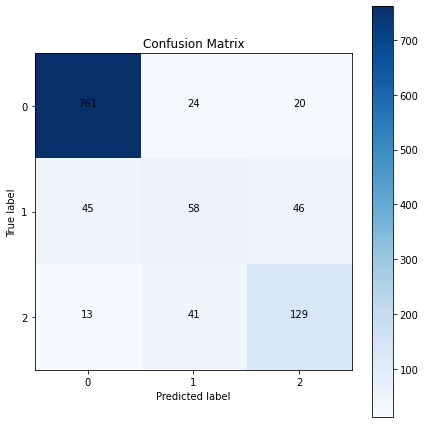

In [11]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

# train_data = np.column_stack((train_data, train_target['EMB_MIC_y'].values))
# test_data = np.column_stack((test_data, test_target['EMB_MIC_y'].values))
train_target_z = train_target['EMB_MIC'].values
test_target_z = test_target['EMB_MIC'].values

def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min-1, target_max+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

# # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_data, test_data, train_target_z, test_target_z

# Create the XGBoost model
model_sir = xgb.XGBClassifier()
model_sir.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model_sir.predict(X_test)

# Evaluate the model_sir
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

#testing
# cutoff = 4
# test_target_sir = y_test.astype(int) #(target_mic_list  >= cutoff).astype(int)
# test_predictions_sir = y_pred.astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

cutoff = 2
test_target_sir = (np.squeeze(np.array(y_test)) >= cutoff).astype(int) #(target_mic_list  >= cutoff).astype(int)
test_predictions_sir = (np.squeeze(np.array(y_pred)) >= cutoff).astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

# auc = roc_auc_score(test_target_sir, test_predictions_sir)
# print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_sir, test_predictions_sir).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)


conf_matrix = confusion_matrix(y_test, y_pred)

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    # Annotate the confusion matrix with the values
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, f'{cm[i, j]}', horizontalalignment='center', color='black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

# Get the unique labels from y_true for the class labels
class_names = unique_labels(y_test, y_pred)

# Plot the confusion matrix
plot_confusion_matrix(conf_matrix, classes=class_names)

### corrective ensemble

#### no res feed + bi dr pred

In [12]:
X_train, X_test, y_train, y_test = train_data, test_data, train_target_x, test_target_x

pred_list = []
true_list = []
for x, y in zip(X_test, y_test):
    y_pred = model.predict([x])[0]
    y_pred_bi = model_bi.predict([x])[0]
    if y_pred == 4 and y_pred_bi == 0:
        y_pred = 3
    elif y_pred == 3 and y_pred_bi == 1:
        y_pred =4
    pred_list.append(y_pred)
    true_list.append(y)
    # print('=========')
    # y_pred = model.predict([x])
    # if is_within_doubling_dilution(y_pred, y, target_min, target_max):
    #     pass
    # else:
    #     print('not within doubling dilution')
    #     print(y_pred[0], y)
    # if int(y>4) != int(y_pred[0]>4):
    #     print('dr pred problem')
    #     print(int(y>4), int(y_pred[0]>4))
    #     print(y_pred[0], y)

In [ ]:
y_pred = pred_list
y_test = true_list
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

target_min, target_max = y_train.min(), y_train.max()

doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(y_pred, y_test)])
print(f"Doubling Dilution Accuracy: {doubling_dilution_accuracy * 100:.2f}%")

#testing
cutoff = 4
test_target_bi = (np.squeeze(np.array(y_test)) >= cutoff).astype(int) #(target_mic_list  >= cutoff).astype(int)
test_predictions_bi = (np.squeeze(np.array(y_pred)) >= cutoff).astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

In [ ]:
di_error = 0
mic_error = 0
for y_pred, y in zip(pred_list, true_list):
    # print('=========')
    if is_within_doubling_dilution(y_pred, y, target_min, target_max):
        pass
    else:
        mic_error += 1

        # print('not within doubling dilution')
        # print(y_pred[0], y)
    if int(y>=4) != int(y_pred>=4):
        print(int(y>=4) == int(y_pred>=4))
        print('dr pred problem')
        print(int(y>=4), int(y_pred>=4))
        print(y_pred, y)
        di_error += 1   
            
print('di_error', 'mic_error')
print(di_error, mic_error)

In [15]:
di_error = 0
mic_error = 0
for y_pred, y in zip(pred_list, true_list):
    # print('=========')
    if is_within_doubling_dilution(y_pred, y, target_min, target_max):
        pass
    else:
        mic_error += 1

        # print('not within doubling dilution')
        # print(y_pred[0], y)
    if int(y>=4) != int(y_pred>=4):
        # print(int(y>=4) == int(y_pred>=4))
        # print('dr pred problem')
        # print(int(y>=4), int(y_pred>=4))
        # print(y_pred, y)
        di_error += 1   
            
print('di_error', 'mic_error')
print(di_error, mic_error)

di_error mic_error
123 84


#### no res feed + bi dr pred + SIR pred


In [16]:
mic_series_sir = mic_aa['EMB_MIC'].apply(lambda x: 2 if x >= 8 else (0 if x <= 2 else 1))


In [ ]:
true4pred3 = 0
true3pred4 = 0
for x, y in zip(X_test, y_test):
    y_pred = model.predict([x])[0]
    y_pred_bi = model_bi.predict([x])[0]
    y_pred_sir = model_sir.predict([x])[0]
    if y_pred != y:
        if y_pred >= 4 and y_pred_bi == 0:
            print('y_pred >= 4 and y_pred_bi == 0')
            print(y_pred, y_pred_bi, y_pred_sir)
            print(y)
        elif y_pred <= 4 and y_pred_bi == 1:
            print('y_pred <= 3 and y_pred_bi == 1')
            print(y_pred, y_pred_bi, y_pred_sir)
            print(y)
    if y_pred == 4 and y == 3:
        true4pred3 += 1
    elif y_pred == 3 and y == 4:
        true3pred4 += 1        

In [18]:
X_train, X_test, y_train, y_test = train_data, test_data, train_target_x, test_target_x

pred_list = []
true_list = []
for x, y in zip(X_test, y_test):
    y_pred = model.predict([x])[0]
    y_pred_bi = model_bi.predict([x])[0]
    y_pred_sir = model_sir.predict([x])[0]
    
    if y_pred_sir == 2 and y_pred == 3:
        y_pred = 4
    if y_pred_sir == 1 and y_pred == 4:
        y_pred = 3
        
    if y_pred == 4 and y_pred_bi == 0:
        y_pred = 3
    elif y_pred == 3 and y_pred_bi == 1:
        y_pred =4
    pred_list.append(y_pred)
    true_list.append(y)
    # print('=========')
    # y_pred = model.predict([x])
    # if is_within_doubling_dilution(y_pred, y, target_min, target_max):
    #     pass
    # else:
    #     print('not within doubling dilution')
    #     print(y_pred[0], y)
    # if int(y>4) != int(y_pred[0]>4):
    #     print('dr pred problem')
    #     print(int(y>4), int(y_pred[0]>4))
    #     print(y_pred[0], y)

In [22]:
y_pred = pred_list
y_test = true_list
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

target_min, target_max = y_train.min(), y_train.max()

doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(y_pred, y_test)])
print(f"Doubling Dilution Accuracy: {doubling_dilution_accuracy * 100:.2f}%")

#testing
cutoff = 4
test_target_bi = (np.squeeze(np.array(y_test)) >= cutoff).astype(int) #(target_mic_list  >= cutoff).astype(int)
test_predictions_bi = (np.squeeze(np.array(y_pred)) >= cutoff).astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)
# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

Accuracy: 0.48284960422163586
Doubling Dilution Accuracy: 92.61%
AUC: 0.8052548372684468
Sensitivity: 0.6775956284153005
Specificity: 0.9329140461215933


### with res feed

In [20]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score

train_target_x = train_target['EMB_MIC_x'].values
test_target_x = test_target['EMB_MIC_x'].values

def is_within_doubling_dilution(pred, target, target_min, target_max):
    _ = np.arange(target_min-1, target_max+2, 1)
    index = [i for i, x in enumerate(_) if x == target][0]
    return (_[index-1] <= pred <= _[index+1])

# # Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_data, test_data, train_target_x, test_target_x

# Create the XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

target_min, target_max = y_train.min(), y_train.max()

doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(y_pred, y_test)])
print(f"Doubling Dilution Accuracy: {doubling_dilution_accuracy * 100:.2f}%")

#testing
cutoff = 4
test_target_bi = (np.squeeze(np.array(y_test)) >= cutoff).astype(int) #(target_mic_list  >= cutoff).astype(int)
test_predictions_bi = (np.squeeze(np.array(y_pred)) >= cutoff).astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

Accuracy: 0.47845206684256814
Doubling Dilution Accuracy: 92.44%
AUC: 0.7922294394611128
Sensitivity: 0.6557377049180327
Specificity: 0.9287211740041929


#### with res feed + bi dr pred

In [21]:
X_train, X_test, y_train, y_test = train_data, test_data, train_target_x, test_target_x

pred_list = []
true_list = []
for x, y in zip(X_test, y_test):
    y_pred = model.predict([x])[0]
    y_pred_bi = model_bi.predict([x])[0]
    if y_pred == 4 and y_pred_bi == 0:
        y_pred = 3
    elif y_pred == 3 and y_pred_bi == 1:
        y_pred =4
    pred_list.append(y_pred)
    true_list.append(y)
    # print('=========')
    # y_pred = model.predict([x])
    # if is_within_doubling_dilution(y_pred, y, target_min, target_max):
    #     pass
    # else:
    #     print('not within doubling dilution')
    #     print(y_pred[0], y)
    # if int(y>4) != int(y_pred[0]>4):
    #     print('dr pred problem')
    #     print(int(y>4), int(y_pred[0]>4))
    #     print(y_pred[0], y)

In [36]:
y_pred = pred_list
y_test = true_list
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

target_min, target_max = y_train.min(), y_train.max()

doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(y_pred, y_test)])
print(f"Doubling Dilution Accuracy: {doubling_dilution_accuracy * 100:.2f}%")

#testing
cutoff = 4
test_target_bi = (np.squeeze(np.array(y_test)) >= cutoff).astype(int) #(target_mic_list  >= cutoff).astype(int)
test_predictions_bi = (np.squeeze(np.array(y_pred)) >= cutoff).astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

Accuracy: 0.5153913808267371
Doubling Dilution Accuracy: 94.37%
AUC: 0.8331786782142488
Sensitivity: 0.7103825136612022
Specificity: 0.9559748427672956


### 1437 snps

In [25]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np

# def is_within_doubling_dilution(pred, target, target_min, target_max):
#     # Ensure target_min and target_max are scalars
#     target_min = target_min.item() if isinstance(target_min, np.ndarray) or isinstance(target_min, pd.Series) else target_min
#     target_max = target_max.item() if isinstance(target_max, np.ndarray) or isinstance(target_max, pd.Series) else target_max

#     # Create a range based on the scalar values of target_min and target_max
#     dilution_range = np.arange(target_min - 1, target_max + 2, 1)
    
#     # Find the index of the target value
#     index = np.where(dilution_range == target)[0][0]  # Use np.where to find the index
    
#     # Check if prediction is within the acceptable range
#     return dilution_range[index - 1] <= pred <= dilution_range[index + 1]



# Load the data
cryptic_drs = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/1473_sample_drs_cryptic_emb.npy', allow_pickle=True)
cryptic_snps = np.load('/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/1473_snps_cryptic_emb.npy', allow_pickle=True)

# Example usage
target_min, target_max = cryptic_drs.min().values, cryptic_drs.max().values

# Convert to pandas DataFrame
cryptic_drs = pd.DataFrame(cryptic_drs)

# Combine the features and target variable
data = cryptic_snps
target = cryptic_drs

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

# Create the XGBoost model
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

target_min, target_max = cryptic_drs.min().values, cryptic_drs.max().values

doubling_dilution_accuracy = np.mean([is_within_doubling_dilution(pred, true, target_min, target_max) for pred, true in zip(y_pred, y_test)])
print(f"Doubling Dilution Accuracy: {doubling_dilution_accuracy * 100:.2f}%")

#testing
cutoff = 4
test_target_bi = (np.squeeze(np.array(y_test)) >= cutoff).astype(int) #(target_mic_list  >= cutoff).astype(int)
test_predictions_bi = (np.squeeze(np.array(y_pred)) >= cutoff).astype(int)  #(np.array(pred_mic_list) >= cutoff).astype(int)

auc = roc_auc_score(test_target_bi, test_predictions_bi)
print("AUC:", auc)

# Calculate confusion matrix components
tn, fp, fn, tp = confusion_matrix(test_target_bi, test_predictions_bi).ravel()

# Calculate sensitivity (recall)
sensitivity = tp / (tp + fn)
print("Sensitivity:", sensitivity)

# Calculate specificity
specificity = tn / (tn + fp)
print("Specificity:", specificity)

OSError: Failed to interpret file '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/1473_snps_cryptic_emb.npy' as a pickle

In [26]:
import pickle

file_path = '/mnt/storageG1/lwang/Projects/tb_dr_MIC_v2/individual_models/1473_snps_cryptic_emb.npy'
with open(file_path, 'rb') as file:
    data = pickle.load(file)
print("Data loaded successfully with pickle.")


EOFError: Ran out of input